In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import igraph as ig
import numpy as np
df = pd.read_csv('soc-sign-bitcoinalpha.csv')

# -- Build Trust / Distrust Subgraphs --
G = nx.DiGraph()
for index, row in df.iterrows():
    G.add_edge(
        row['SOURCE'], 
        row['TARGET'],
        rating=row['RATING'],           
        time=row['TIME'],
    )


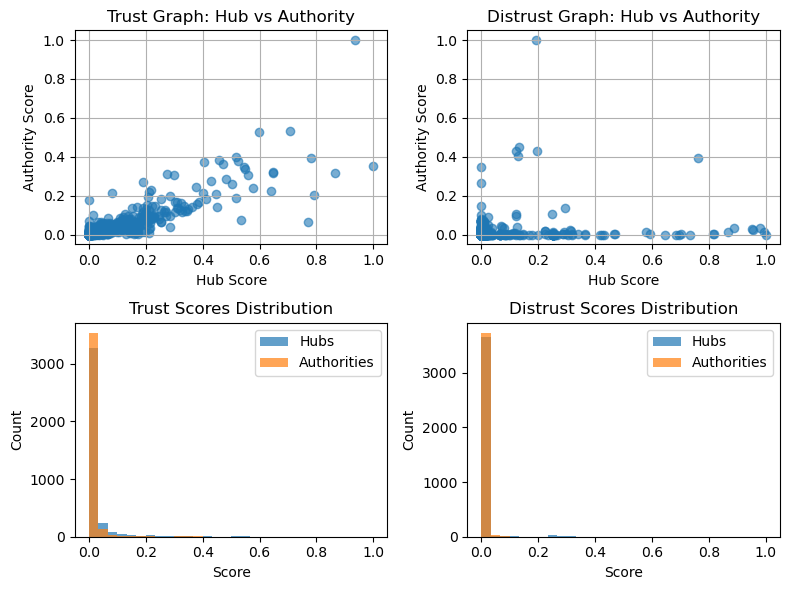

In [2]:
edge_list = [(u, v, d['rating']) for u, v, d in G.edges(data=True)]
g = ig.Graph.TupleList(edge_list, directed=True, edge_attrs=['rating'])
# Use absolute ratings as 'weight' so HITS sees positive weights
g.es['weight'] = [abs(r) for r in g.es['rating']]

# Trust subgraph (only rating > 0)
trust_eids = [e.index for e in g.es if e['rating'] > 0]
g_trust = g.subgraph_edges(trust_eids, delete_vertices=False)
g_trust.es['weight'] = g_trust.es['rating']  # original positive ratings

# Distrust subgraph (only rating < 0)
distrust_eids = [e.index for e in g.es if e['rating'] < 0]
g_distrust = g.subgraph_edges(distrust_eids, delete_vertices=False)
# convert negative ratings to positive weights
g_distrust.es['weight'] = [abs(r) for r in g_distrust.es['rating']]

# --- Compute HITS scores on each ---
h_t = g_trust.hub_score(weights='weight')
a_t = g_trust.authority_score(weights='weight')
h_d = g_distrust.hub_score(weights='weight')
a_d = g_distrust.authority_score(weights='weight')

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Trust: Hub vs Authority scatter
axes[0, 0].scatter(h_t, a_t, alpha=0.6)
axes[0, 0].set_title('Trust Graph: Hub vs Authority')
axes[0, 0].set_xlabel('Hub Score')
axes[0, 0].set_ylabel('Authority Score')
axes[0, 0].grid(True)

# Distrust: Hub vs Authority scatter
axes[0, 1].scatter(h_d, a_d, alpha=0.6)
axes[0, 1].set_title('Distrust Graph: Hub vs Authority')
axes[0, 1].set_xlabel('Hub Score')
axes[0, 1].set_ylabel('Authority Score')
axes[0, 1].grid(True)

# Trust: score distributions
axes[1, 0].hist(h_t, bins=30, alpha=0.7, label='Hubs')
axes[1, 0].hist(a_t, bins=30, alpha=0.7, label='Authorities')
axes[1, 0].set_title('Trust Scores Distribution')
axes[1, 0].set_xlabel('Score')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

# Distrust: score distributions
axes[1, 1].hist(h_d, bins=30, alpha=0.7, label='Hubs')
axes[1, 1].hist(a_d, bins=30, alpha=0.7, label='Authorities')
axes[1, 1].set_title('Distrust Scores Distribution')
axes[1, 1].set_xlabel('Score')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

plt.tight_layout()
plt.show()



In [3]:
vertex_ids = [v['name'] for v in g.vs]  # Get vertex names from original graph

# Create DataFrame with all scores
scores_df = pd.DataFrame({
    'vertex_id': vertex_ids,
    'trust_hub_score': h_t,
    'trust_auth_score': a_t,
    'distrust_hub_score': h_d,
    'distrust_auth_score': a_d
})

# Save to CSV
scores_df.to_csv('hits_scores.csv', index=False)
print("All HITS scores saved to 'hits_scores.csv'")

All HITS scores saved to 'hits_scores.csv'


In [4]:
def detect_distrust_auth_outliers(scores_df, top_percentile=3):
    """
    Detect top 5% outliers in distrust authority scores
    
    Parameters:
    - scores_df: DataFrame containing 'distrust_auth_score' column
    - top_percentile: Percentage cutoff for outliers (default 5%)
    
    Returns:
    - DataFrame with added outlier flag column
    """
    # Calculate threshold for top 5%
    threshold = np.percentile(scores_df['distrust_auth_score'], 100 - top_percentile)
    
    # Add outlier flag
    scores_df['distrust_auth_outlier'] = (scores_df['distrust_auth_score'] >= threshold).astype(int)
    
    return scores_df, threshold

# Usage:
# First load or compute scores_df as before
scores_df = pd.DataFrame({
    'vertex_id': vertex_ids,
    'trust_hub_score': h_t,
    'trust_auth_score': a_t,
    'distrust_hub_score': h_d,
    'distrust_auth_score': a_d
})

# Detect outliers (top 5% distrust auth scores)
outlier_df, threshold = detect_distrust_auth_outliers(scores_df)
print(f"Distrust auth outlier threshold: {threshold:.4f}")

# Get list of outlier nodes
outlier_nodes = outlier_df[outlier_df['distrust_auth_outlier'] == 1]['vertex_id'].tolist()
print(f"Found {len(outlier_nodes)} distrust auth outliers")

# Then run fraud detection with this outlier requirement

#side note: outliers under adjusted boxplot and extreme value theorem were 2 previous way to flag high risk node using distrust authority score, but first one flagged too much (555 out of ~630 nodes that have negative indegree), second one flagged too less(only the highest one)

Distrust auth outlier threshold: 0.0147
Found 114 distrust auth outliers


Positive extreme threshold: 0.3333333333333333
Positive reciprocity threshold: 0.16666666666666666
=== FRAUD NODE CATEGORIZATION ===

Nodes meeting only extreme rating threshold: 18
Nodes meeting only reciprocity threshold: 19
Nodes meeting both thresholds: 30

=== SAMPLE NODES ===

extreme-only nodes: [1024, 1368, 1421, 971, 749, 7531, 7562, 7558, 7535, 870, 7337, 1807, 344, 745, 1915, 3337, 7530, 1062]

reciprocal-only nodes: [276, 543, 475, 446, 590, 468, 221, 7328, 7334, 569, 246, 604, 195, 1103, 285, 307, 515, 445, 426]

All nodes meeting both criteria: [430, 377, 554, 709, 525, 7604, 692, 7517, 7536, 7602, 7601, 7599, 7598, 5533, 243, 726, 533, 421, 325, 2225, 581, 213, 363, 388, 584, 679, 387, 828, 577, 628]

=== FRAUD RINGS ===

Detected 2 rings with composition:


,ring_size,contains_extreme,contains_recip,contains_both
0,6,False,True,True
1,3,False,False,True


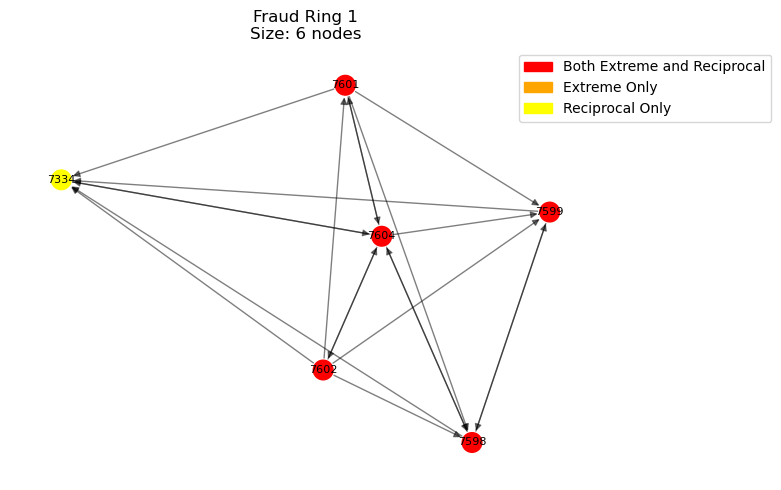

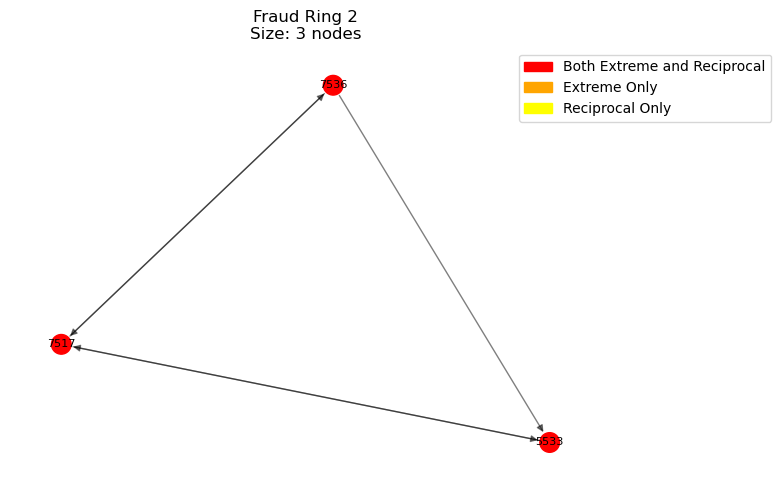

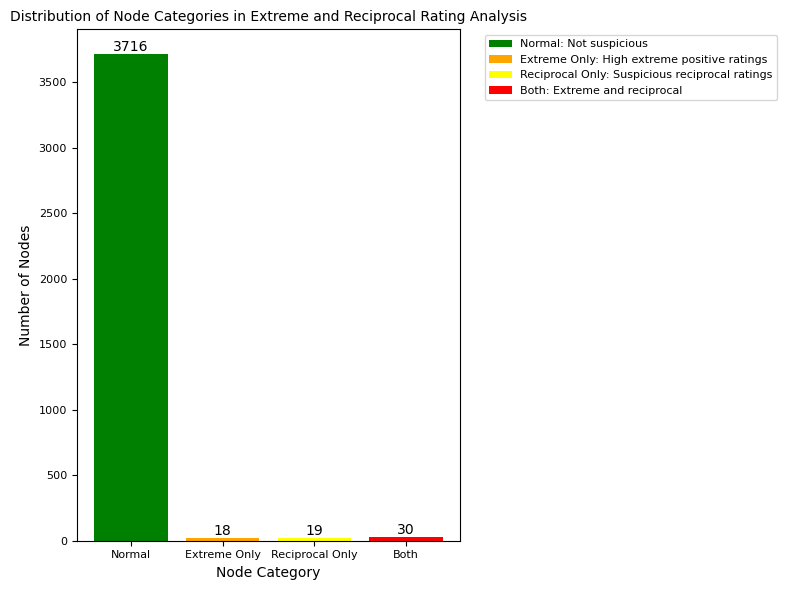

In [5]:
def detect_and_categorize_trust_fraud(G, 
                                    min_outdegree=3,
                                    min_ring_size=3,
                                    top_percentile=1,
                                    outlier_df=None):
    
    # Initialize storage for different groups
    extreme_nodes = []
    recip_nodes = []
    extreme_recip_nodes = []
    
    # Individual Node Analysis
    node_data = []
    
    #             collect all scores
    all_extreme_scores = []
    all_reciprocity_scores = []
    
    for node in G.nodes():
        # Get all edges connected to this node (only positive edges)
        out_edges = [(u, v, d) for u, v, d in G.out_edges(node, data=True) if d['rating'] > 0]
        out_degree = len(out_edges)
        
        # Skip nodes that don't meet minimum out-degree requirement
        if out_degree < min_outdegree:
            node_data.append({
                'node': node,
                'total_edges': out_degree,
                'extreme_count': 0,
                'extreme_ratio': 0,
                'reciprocal_count': 0,
                'suspicious_reciprocal': 0,
                'extreme_score': 0,
                'reciprocity_score': 0,
                'is_extreme': False,
                'is_susp_recip': False
            })
            continue
            
        all_ratings = [d['rating'] for _, _, d in out_edges]
        total_ratings = len(all_ratings)
        
        # Count extreme POSITIVE ratings (e.g., +10)
        extreme_count = sum(1 for r in all_ratings if r == 10)
        extreme_ratio = extreme_count / total_ratings if total_ratings > 0 else 0
        
        # Reciprocity analysis - only positive edges
        reciprocal_pairs = []
        for u, v, d in out_edges:
            if G.has_edge(v, u) and G[v][u]['rating'] > 0:  # Only positive reciprocation
                reciprocal_pairs.append((d['rating'], G[v][u]['rating']))
        
        reciprocal_count = len(reciprocal_pairs)
        suspicious_reciprocal = sum(
            1 for w1, w2 in reciprocal_pairs 
            if w1 == 10 and w2 == 10  # Both extreme positive
        )
        
        # Calculate scores
        extreme_score = extreme_ratio
        reciprocity_score = (suspicious_reciprocal / reciprocal_count 
                           if reciprocal_count > 0 else 0)
        
        all_extreme_scores.append(extreme_score)
        all_reciprocity_scores.append(reciprocity_score)
        
        node_data.append({
            'node': node,
            'total_edges': total_ratings,
            'extreme_count': extreme_count,
            'extreme_ratio': extreme_ratio,
            'reciprocal_count': reciprocal_count,
            'suspicious_reciprocal': suspicious_reciprocal,
            'extreme_score': extreme_score,
            'reciprocity_score': reciprocity_score
        })
    
    # Calculate thresholds 
    extreme_threshold = np.percentile(all_extreme_scores, 100 - top_percentile) if all_extreme_scores else 0
    reciprocity_threshold = np.percentile(all_reciprocity_scores, 100 - top_percentile) if all_reciprocity_scores else 0
    print(f"Positive extreme threshold: {extreme_threshold}")
    print(f"Positive reciprocity threshold: {reciprocity_threshold}")
    
    # Second pass: categorize nodes based on dynamic thresholds
    for i, node in enumerate(G.nodes()):
        # Skip if we didn't process this node in first pass (due to low out-degree)
        if 'extreme_score' not in node_data[i]:
            continue
            
        is_extreme = (node_data[i]['extreme_score'] >= extreme_threshold)
        is_susp_recip = (node_data[i]['reciprocity_score'] >= reciprocity_threshold)
        
        # Update node data with categorization
        node_data[i]['is_extreme'] = is_extreme
        node_data[i]['is_susp_recip'] = is_susp_recip
        node_data[i]['extreme_threshold'] = extreme_threshold
        node_data[i]['reciprocity_threshold'] = reciprocity_threshold
        
        # Categorize node
        if is_extreme and is_susp_recip:
            extreme_recip_nodes.append(node)
        elif is_extreme:
            extreme_nodes.append(node)
        elif is_susp_recip:
            recip_nodes.append(node)
    
    # Create DataFrames for each group
    node_df = pd.DataFrame(node_data)

    # Trust Ring Detection (using all flagged nodes)
    potential_fraud_nodes = extreme_nodes + recip_nodes + extreme_recip_nodes
    ring_data = []
    
    if len(potential_fraud_nodes) >= min_ring_size:
        # Create subgraph with only positive edges between potential fraud nodes
        subgraph = nx.DiGraph()
        for u, v, d in G.edges(data=True):
            if u in potential_fraud_nodes and v in potential_fraud_nodes and d['rating'] > 0:
                subgraph.add_edge(u, v, **d)
        
        # Convert to undirected for connected components (rings)
        undirected_subgraph = subgraph.to_undirected()
        rings = [ring for ring in nx.connected_components(undirected_subgraph) 
                if len(ring) >= min_ring_size]
        
        # Get outlier nodes if provided
        outlier_nodes = []
        if outlier_df is not None:
            outlier_nodes = outlier_df[outlier_df['distrust_auth_outlier'] == 1]['vertex_id'].tolist()
        
        for ring in rings:
            # Only include rings that contain at least one outlier (if outliers provided)
            if not outlier_nodes or set(ring) & set(outlier_nodes):
                ring_subgraph = subgraph.subgraph(ring)
                edge_attrs = nx.get_edge_attributes(ring_subgraph, 'rating')
                extreme_edges = sum(1 for r in edge_attrs.values() if r == 10)
                
                ring_data.append({
                    'ring_size': len(ring),
                    'nodes': list(ring),
                    'extreme_ratio': extreme_edges / len(edge_attrs) if edge_attrs else 0,
                    'contains_extreme': len(set(ring) & set(extreme_nodes)) > 0,
                    'contains_recip': len(set(ring) & set(recip_nodes)) > 0,
                    'contains_both': len(set(ring) & set(extreme_recip_nodes)) > 0,
                    'contains_outlier': len(set(ring) & set(outlier_nodes)) > 0 if outlier_nodes else False,
                    'is_positive_ring': True
                })
                
    ring_df = pd.DataFrame(ring_data)
    
    return {
        'extreme_nodes': extreme_nodes,
        'recip_nodes': recip_nodes,
        'extreme_recip_nodes': extreme_recip_nodes,
        'node_df': node_df,
        'ring_df': ring_df,
        'extreme_threshold': extreme_threshold,
        'reciprocity_threshold': reciprocity_threshold
    }

# Run detection and categorization for positive edges only
positive_results = detect_and_categorize_trust_fraud(
    G,
    min_outdegree=3,
    min_ring_size=3,
    top_percentile=3,
    outlier_df=outlier_df
)

# Generate report
def generate_categorized_report(results):
    print("=== FRAUD NODE CATEGORIZATION ===")
    print(f"\nNodes meeting only extreme rating threshold: {len(results['extreme_nodes'])}")
    print(f"Nodes meeting only reciprocity threshold: {len(results['recip_nodes'])}")
    print(f"Nodes meeting both thresholds: {len(results['extreme_recip_nodes'])}")
    
    print("\n=== SAMPLE NODES ===")
    print("\nextreme-only nodes:", results['extreme_nodes'])
    print("\nreciprocal-only nodes:", results['recip_nodes'])
    print("\nAll nodes meeting both criteria:", results['extreme_recip_nodes'])
    
    print("\n=== FRAUD RINGS ===")
    if not results['ring_df'].empty:
        print(f"\nDetected {len(results['ring_df'])} rings with composition:")
        display(results['ring_df'][['ring_size', 'contains_extreme', 'contains_recip', 'contains_both']])
    else:
        print("\nNo fraud rings detected")
generate_categorized_report(positive_results)

# Visualization
def plot_categorized_rings(ring_df, G, positive_results):
    if not ring_df.empty:
        for i, row in ring_df.iterrows():
            plt.figure(figsize=(8, 5))  # Slightly larger figure for legend
            subgraph = G.subgraph(row['nodes'])
            
            # Color nodes by category
            node_colors = []
            for n in row['nodes']:
                if n in positive_results['extreme_recip_nodes']:
                    node_colors.append('red')  # Both extreme and reciprocal
                elif n in positive_results['extreme_nodes']:
                    node_colors.append('orange')  # Extreme only
                else:
                    node_colors.append('yellow')  # Reciprocal only
            
            pos = nx.spring_layout(subgraph)
            nx.draw_networkx_nodes(subgraph, pos, node_size=200, node_color=node_colors)
            nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
            nx.draw_networkx_labels(subgraph, pos, font_size=8)
            
            # Create legend
            legend_patches = [
                mpatches.Patch(color='red', label='Both Extreme and Reciprocal'),
                mpatches.Patch(color='orange', label='Extreme Only'),
                mpatches.Patch(color='yellow', label='Reciprocal Only')
            ]
            
            plt.legend(handles=legend_patches, 
                      loc='upper right', 
                      bbox_to_anchor=(1.3, 1),  # Adjust position if needed
                      frameon=True)
            
            plt.title(f"Fraud Ring {i+1}\nSize: {len(row['nodes'])} nodes")
            plt.axis('off')
            plt.tight_layout()  # Prevent legend from being cut off
            plt.show()

plot_categorized_rings(positive_results['ring_df'], G,positive_results)

def plot_fraud_categories_histogram(results):
    # Extract counts for each category
    extreme_count = len(results['extreme_nodes'])
    recip_count = len(results['recip_nodes'])
    both_count = len(results['extreme_recip_nodes'])
    
    # Count normal nodes (nodes that don't fall into any suspicious category)
    node_df = results['node_df']
    normal_count = len(node_df[(~node_df['is_extreme']) & (~node_df['is_susp_recip'])])
    
    # Prepare data for plotting
    categories = ['Normal', 'Extreme Only', 'Reciprocal Only', 'Both']
    counts = [normal_count, extreme_count, recip_count, both_count]
    colors = ['green', 'orange', 'yellow', 'red']
    
    # Create histogram
    plt.figure(figsize=(8, 6))
    bars = plt.bar(categories, counts, color=colors)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom')
    
    # Customize plot
    plt.title('Distribution of Node Categories in Extreme and Reciprocal Rating Analysis', fontsize=10)
    plt.xlabel('Node Category', fontsize=10)
    plt.ylabel('Number of Nodes', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    # Add legend
    legend_labels = [
        'Normal: Not suspicious',
        'Extreme Only: High extreme positive ratings',
        'Reciprocal Only: Suspicious reciprocal ratings',
        'Both: Extreme and reciprocal'
    ]
    plt.legend(bars, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Call the function with your results
plot_fraud_categories_histogram(positive_results)

#possible improvement: we need a better, more statistically reliable and interpretable formula for classify node with extreme and reciprocal rating. 

OUTLIERS WITH EXTREME RATING ONLY (NO RECIPROCITY)
Count: 4

Sample nodes:


,vertex_id,distrust_auth_score,extreme_ratio,reciprocity_score
0,7562,0.022585,0.333333,0.0
1,7535,0.071952,0.333333,0.0
2,7558,0.038380,0.333333,0.0
3,7530,0.038719,0.333333,0.0



OUTLIERS WITH RECIPROCITY ONLY (NO EXTREME RATINGS)
Count: 3

Sample nodes:


,vertex_id,distrust_auth_score,extreme_ratio,reciprocity_score
0,7334,0.147253,0.142857,0.200000
1,285,0.023284,0.153846,0.166667
2,1103,0.023284,0.200000,0.200000



OUTLIERS MEETING BOTH EXTREME AND RECIPROCITY THRESHOLDS
Count: 8

All nodes:


,vertex_id,distrust_auth_score,extreme_ratio,reciprocity_score
0,7602,0.452418,1.000000,1.000000
1,7601,0.403511,1.000000,1.000000
2,7599,0.430427,1.000000,1.000000
3,7598,0.430427,1.000000,1.000000
4,7604,1.000000,1.000000,1.000000
5,5533,0.063060,0.666667,0.666667
6,7517,0.063060,0.857143,0.333333
7,7536,0.063060,1.000000,1.000000


<Figure size 1200x600 with 0 Axes>

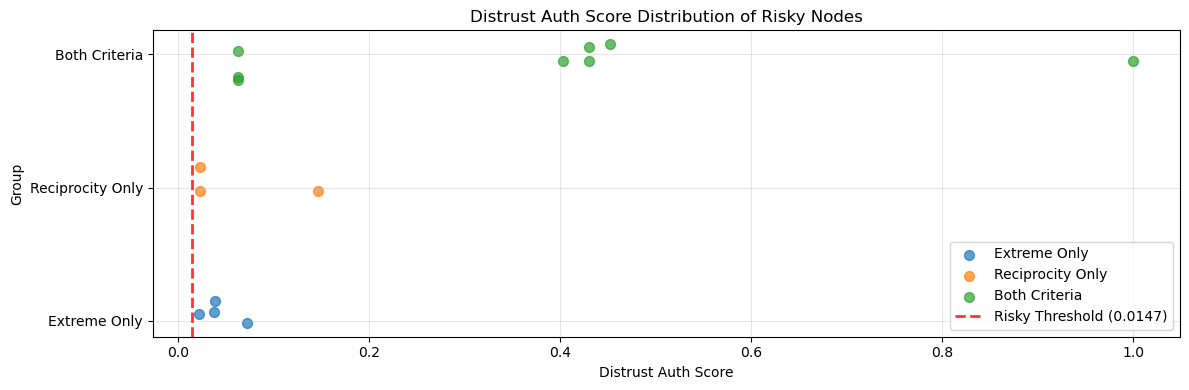


SUMMARY OF OUTLIER CATEGORIES:


,Category,Count
0,Extreme Ratings Only,4
1,Reciprocity Only,3
2,Both Extreme and Reciprocity,8
3,Total Outliers,15


In [6]:
# final report
if 'distrust_auth_outlier' not in outlier_df.columns:
    outlier_df['distrust_auth_outlier'] = (outlier_df['distrust_auth_score'] >= threshold).astype(int)

# Merge all relevant data
merged_df = pd.merge(
    outlier_df[['vertex_id', 'distrust_auth_outlier', 'distrust_auth_score']],
    positive_results['node_df'][['node', 'is_extreme', 'is_susp_recip']],
    left_on='vertex_id',
    right_on='node',
    how='left'
)

# List 1: Outliers that meet ONLY extreme rating threshold (not reciprocity)
outlier_extreme_only = merged_df[
    (merged_df['distrust_auth_outlier'] == 1) &
    (merged_df['is_extreme'] == True) &
    (merged_df['is_susp_recip'] == False)
]['vertex_id'].tolist()

# List 2: Outliers that meet ONLY reciprocity threshold (not extreme)
outlier_recip_only = merged_df[
    (merged_df['distrust_auth_outlier'] == 1) &
    (merged_df['is_extreme'] == False) &
    (merged_df['is_susp_recip'] == True)
]['vertex_id'].tolist()

# List 3: Outliers that meet BOTH extreme and reciprocity thresholds
outlier_extreme_recip = merged_df[
    (merged_df['distrust_auth_outlier'] == 1) &
    (merged_df['is_extreme'] == True) &
    (merged_df['is_susp_recip'] == True)
]['vertex_id'].tolist()

# Create detailed DataFrames for each group
def create_detailed_df(node_list):
    detailed_df = pd.merge(
        scores_df[scores_df['vertex_id'].isin(node_list)],
        positive_results['node_df'][positive_results['node_df']['node'].isin(node_list)],
        left_on='vertex_id',
        right_on='node',
        how='left'
    )
    # Add distrust auth score if not already present
    if 'distrust_auth_score' not in detailed_df.columns:
        detailed_df = pd.merge(
            detailed_df,
            outlier_df[['vertex_id', 'distrust_auth_score']],
            on='vertex_id',
            how='left'
        )
    return detailed_df.drop(columns=['node'])

outlier_extreme_only_df = create_detailed_df(outlier_extreme_only)
outlier_recip_only_df = create_detailed_df(outlier_recip_only)
outlier_extreme_recip_df = create_detailed_df(outlier_extreme_recip)

# Generate report
print("="*80)
print("OUTLIERS WITH EXTREME RATING ONLY (NO RECIPROCITY)")
print("="*80)
print(f"Count: {len(outlier_extreme_only)}")
print("\nSample nodes:")
display(outlier_extreme_only_df[[
    'vertex_id', 
    'distrust_auth_score',
    'extreme_ratio',
    'reciprocity_score'
]])

print("\n" + "="*80)
print("OUTLIERS WITH RECIPROCITY ONLY (NO EXTREME RATINGS)")
print("="*80)
print(f"Count: {len(outlier_recip_only)}")
print("\nSample nodes:")
display(outlier_recip_only_df[[
    'vertex_id', 
    'distrust_auth_score',
    'extreme_ratio',
    'reciprocity_score'
]])

print("\n" + "="*80)
print("OUTLIERS MEETING BOTH EXTREME AND RECIPROCITY THRESHOLDS")
print("="*80)
print(f"Count: {len(outlier_extreme_recip)}")
print("\nAll nodes:")
display(outlier_extreme_recip_df[[
    'vertex_id', 
    'distrust_auth_score',
    'extreme_ratio',
    'reciprocity_score'
]])

# Visualization
plt.figure(figsize=(12, 6))

# Plot distribution comparison
plt.figure(figsize=(12, 4))

# Add small random jitter to y-axis to prevent overlap
np.random.seed(42)  # For reproducible jitter
jitter_amount = 0.1

y1 = np.full(len(outlier_extreme_only_df), 0) + np.random.normal(0, jitter_amount, len(outlier_extreme_only_df))
y2 = np.full(len(outlier_recip_only_df), 1) + np.random.normal(0, jitter_amount, len(outlier_recip_only_df))
y3 = np.full(len(outlier_extreme_recip_df), 2) + np.random.normal(0, jitter_amount, len(outlier_extreme_recip_df))

plt.scatter(outlier_extreme_only_df['distrust_auth_score'], y1, 
           alpha=0.7, label='Extreme Only', s=50)
plt.scatter(outlier_recip_only_df['distrust_auth_score'], y2, 
           alpha=0.7, label='Reciprocity Only', s=50)
plt.scatter(outlier_extreme_recip_df['distrust_auth_score'], y3, 
           alpha=0.7, label='Both Criteria', s=50)
plt.axvline(x=0.0147, color='red', linestyle='--', linewidth=2, alpha=0.8, 
           label='Risky Threshold (0.0147)')

plt.xlabel('Distrust Auth Score')
plt.ylabel('Group')
plt.title('Distrust Auth Score Distribution of Risky Nodes')
plt.yticks([0, 1, 2], ['Extreme Only', 'Reciprocity Only', 'Both Criteria'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary table
summary_data = {
    'Category': [
        'Extreme Ratings Only',
        'Reciprocity Only',
        'Both Extreme and Reciprocity',
        'Total Outliers'
    ],
    'Count': [
        len(outlier_extreme_only),
        len(outlier_recip_only),
        len(outlier_extreme_recip),
        len(outlier_extreme_only) + len(outlier_recip_only) + len(outlier_extreme_recip)
    ]
}
summary_df = pd.DataFrame(summary_data)
print("\nSUMMARY OF OUTLIER CATEGORIES:")
display(summary_df)